# **2 CHARTS AND CORRELATIONS**

### 2.1 Chart 1: Pie chart - Nodes with Sev2 before Sev1 vs Total Nodes

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Berkeley/PROJECT/Test')

Mounted at /content/drive


<ipython-input-3-6e14d6a28112>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered_by_sequence = df_filtered.groupby('NodeId').apply(filter_unpreceded_sev1).reset_index(drop=True)


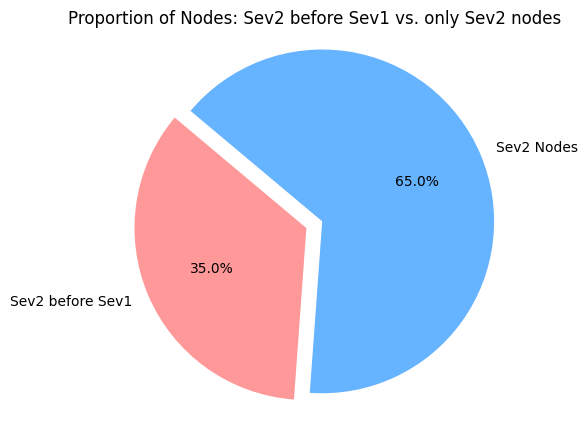

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Telemetry_ready4ML.csv', parse_dates=['PreciseTimeStamp'])

# Step 1: Remove nodes that only experienced Sev1 but no Sev2
nodes_to_filter_out = df.groupby('NodeId').filter(
    lambda x: ('Sev1' in x['Severity'].values) and ('Sev2' not in x['Severity'].values)
)['NodeId'].unique()
df_filtered = df[~df['NodeId'].isin(nodes_to_filter_out)].copy()

# Step 2: Identify nodes that had both Sev1 and a preceding Sev2
def has_sev2_before_sev1(group):
    sev1_timestamps = group[group['Severity'] == 'Sev1']['PreciseTimeStamp']
    sev2_timestamps = group[group['Severity'] == 'Sev2']['PreciseTimeStamp']
    if sev1_timestamps.empty or sev2_timestamps.empty:
        return False
    for sev1_ts in sev1_timestamps:
        if any(sev2_ts < sev1_ts for sev2_ts in sev2_timestamps):
            return True
    return False

nodes_with_sev2_before_sev1 = df_filtered.groupby('NodeId').filter(has_sev2_before_sev1)['NodeId'].unique()

# Step 3: Row-level filtering for Sev1 incidents not preceded by Sev2
def filter_unpreceded_sev1(group):
    group = group.sort_values(by='PreciseTimeStamp')
    rows_to_keep = []
    sev2_encountered = False
    for _, row in group.iterrows():
        if row['Severity'] == 'Sev2':
            rows_to_keep.append(row)
            sev2_encountered = True
        elif row['Severity'] == 'Sev1':
            if sev2_encountered:
                rows_to_keep.append(row)
        else:
            rows_to_keep.append(row)
    return pd.DataFrame(rows_to_keep) if rows_to_keep else pd.DataFrame()

df_filtered_by_sequence = df_filtered.groupby('NodeId').apply(filter_unpreceded_sev1).reset_index(drop=True)

# Step 4: Identify nodes with remaining Sev1
nodes_with_remaining_sev1 = df_filtered_by_sequence[df_filtered_by_sequence['Severity'] == 'Sev1']['NodeId'].unique()

# Pie chart data
num_nodes_with_sev2_before_sev1 = len(nodes_with_remaining_sev1)
total_nodes_final_dataset = df_filtered_by_sequence['NodeId'].nunique()
num_other_nodes = total_nodes_final_dataset - num_nodes_with_sev2_before_sev1

# Plotting the pie chart
labels = ['Sev2 before Sev1', 'Sev2 Nodes']
sizes = [num_nodes_with_sev2_before_sev1, num_other_nodes]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Proportion of Nodes: Sev2 before Sev1 vs. only Sev2 nodes')
plt.axis('equal')
plt.show()

Looks like this data set could support the modelling of Sev2-to-Sev1 transitions providing positive (Sev2→Sev1) and negative (Sev2-only) cases with a temporal context.
However, maybe a class imbalance and limited features could impact model performance unless addressed through feature engineering and careful sampling.

## 2.2 Chart 2: Bar chart - Top RCALevel2 causing Sev1 (all clusters)

<ipython-input-4-bcaf1cf36dd8>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


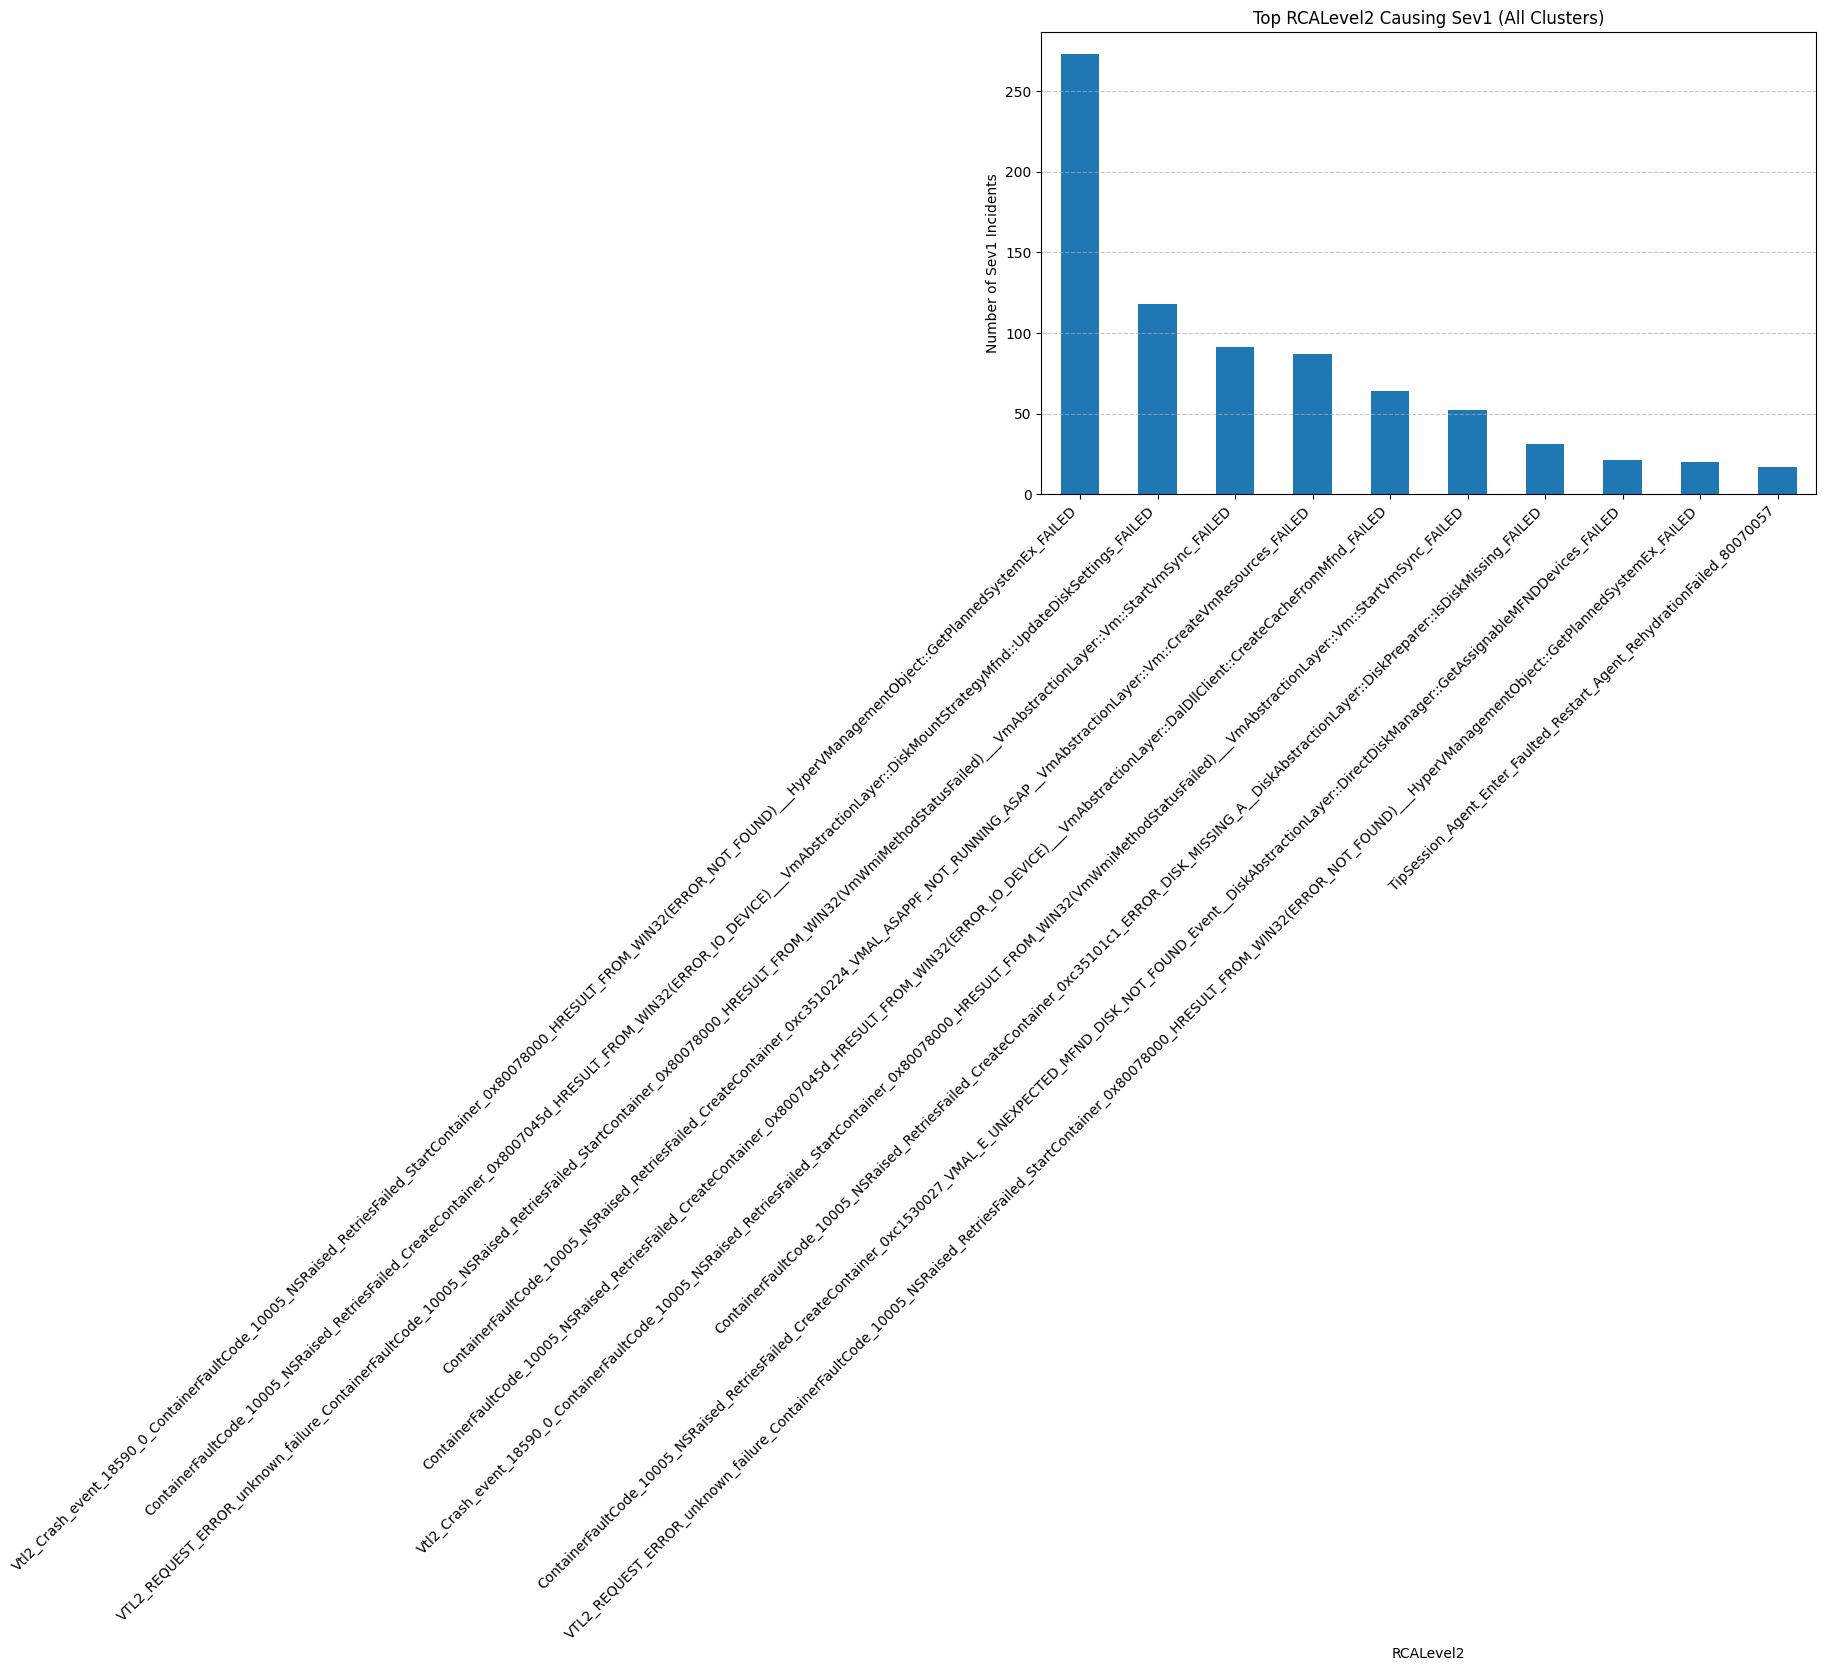

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


# df = pd.read_csv('Telemetry_ready4ML.csv')  # No need If I running sequenctially Uncomment and if not

# Filter only Sev1 incidents
sev1_df = df[df['Severity'] == 'Sev1']

# Count occurrences of each RCALevel2 for Sev1
top_rca_sev1 = sev1_df['RCALevel2'].value_counts().head(10)  # Top 10 root causes

# Plot
plt.figure(figsize=(10, 6))
top_rca_sev1.plot(kind='bar')
plt.title('Top RCALevel2 Causing Sev1 (All Clusters)')
plt.xlabel('RCALevel2')
plt.ylabel('Number of Sev1 Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


mmm Looks like I have to Trim a little the top RCALevel2 contributors

In [5]:
print(top_rca_sev1)

RCALevel2
Vtl2_Crash_event_18590_0_ContainerFaultCode_10005_NSRaised_RetriesFailed_StartContainer_0x80078000_HRESULT_FROM_WIN32(ERROR_NOT_FOUND)___HyperVManagementObject::GetPlannedSystemEx_FAILED               273
ContainerFaultCode_10005_NSRaised_RetriesFailed_CreateContainer_0x8007045d_HRESULT_FROM_WIN32(ERROR_IO_DEVICE)___VmAbstractionLayer::DiskMountStrategyMfnd::UpdateDiskSettings_FAILED                    118
VTL2_REQUEST_ERROR_unknown_failure_ContainerFaultCode_10005_NSRaised_RetriesFailed_StartContainer_0x80078000_HRESULT_FROM_WIN32(VmWmiMethodStatusFailed)___VmAbstractionLayer::Vm::StartVmSync_FAILED     91
ContainerFaultCode_10005_NSRaised_RetriesFailed_CreateContainer_0xc3510224_VMAL_ASAPPF_NOT_RUNNING_ASAP__VmAbstractionLayer::Vm::CreateVmResources_FAILED                                                 87
ContainerFaultCode_10005_NSRaised_RetriesFailed_CreateContainer_0x8007045d_HRESULT_FROM_WIN32(ERROR_IO_DEVICE)___VmAbstractionLayer::DalDllClient::CreateCacheFromMfnd_FAI

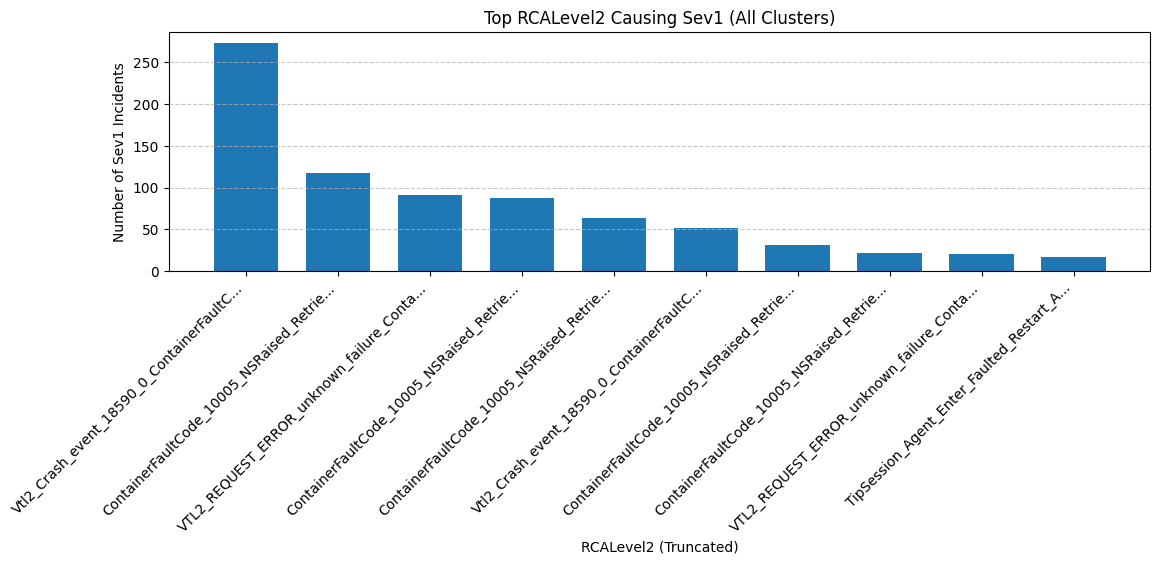

In [6]:
import numpy as np

# Shortened labels, the names are super long
short_labels = [label[:40] + '...' if len(label) > 40 else label for label in top_rca_sev1.index]

# X positions
x_pos = np.arange(len(short_labels))

plt.figure(figsize=(12, 6))
plt.bar(x_pos, top_rca_sev1.values, width=0.7)
plt.xticks(x_pos, short_labels, rotation=45, ha='right')
plt.title('Top RCALevel2 Causing Sev1 (All Clusters)')
plt.xlabel('RCALevel2 (Truncated)')
plt.ylabel('Number of Sev1 Incidents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2)
plt.show()

This is a great insight,  the top Sev2 with rootcause leading to Sev1 Crashes across all nodes all clusters

### 2.3 Chart 3: Average number of Sev2 incidents before a Sev1

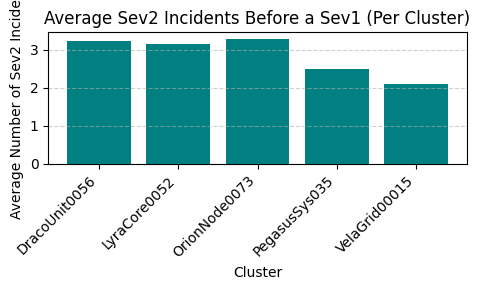

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
df['PreciseTimeStamp'] = pd.to_datetime(df['PreciseTimeStamp'])

# Sort by NodeId and timestamp
df_sorted = df.sort_values(by=['NodeId', 'PreciseTimeStamp'])

# Dictionary to store results per cluster
cluster_avg_counts = {}

# Loop over clusters
for cluster, cluster_group in df_sorted.groupby('ClusterId'):
    sev2_before_sev1_counts = []

    for node_id, node_group in cluster_group.groupby('NodeId'):
        node_group = node_group.reset_index(drop=True)
        sev1_indices = node_group[node_group['Severity'] == 'Sev1'].index

        for sev1_index in sev1_indices:
            sev2_count = node_group.loc[:sev1_index - 1, 'Severity'].value_counts().get('Sev2', 0)
            sev2_before_sev1_counts.append(sev2_count)

    # Calculate average for this cluster
    if sev2_before_sev1_counts:
        avg_count = sum(sev2_before_sev1_counts) / len(sev2_before_sev1_counts)
    else:
        avg_count = 0  # No Sev1 in this cluster

    cluster_avg_counts[cluster] = avg_count

# Prepare data for plotting
clusters = list(cluster_avg_counts.keys())
averages = list(cluster_avg_counts.values())

# Plot
plt.figure(figsize=(5, 3))
plt.bar(clusters, averages, color='teal')
plt.title('Average Sev2 Incidents Before a Sev1 (Per Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Sev2 Incidents')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## 2.4 Chart 4: Sev1 incidentes cross clusters cross months

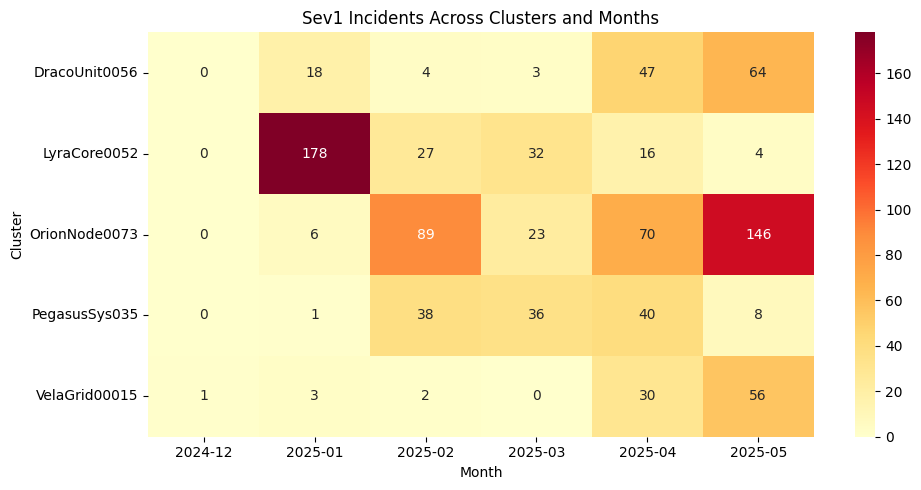

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp and filter Sev1
df['PreciseTimeStamp'] = pd.to_datetime(df['PreciseTimeStamp'])
df['Month'] = df['PreciseTimeStamp'].dt.to_period('M').astype(str)

sev1_df = df[df['Severity'] == 'Sev1']

# Group by Cluster and Month
sev1_counts = sev1_df.groupby(['ClusterId', 'Month']).size().unstack(fill_value=0)

# heat map, is super interesting to see the cascade !
# resembles how we deploy the fixes
# attention 2024-12 is 0 because most of the clusters started in Jan
plt.figure(figsize=(10, 5))
sns.heatmap(sev1_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Sev1 Incidents Across Clusters and Months')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

Looking for Correlations

The Feature that really matters to predict trnsition from Sev2 to Sev1 is the RCALevel1. We need to use the one hot encoding to run a linear regression over those values: Every feature  related to a Sev2 will be encoded as a binary 0 : Does not cause Sev1, 1 : Cause a Sev1

## 2.5 Creating binary for encoding features
* Sev1Caused = 1 if the RCALevel2 feature caused a Sev1
* Sev1Cause = 0 if the RCALevel2 feature didn't caused a Sev1

In [9]:
## Creating the File with 0 and 1
import pandas as pd

# Load the uploaded CSV file
file_path = "Telemetry_ready4ML.csv"
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df["PreciseTimeStamp"] = pd.to_datetime(df["PreciseTimeStamp"])

# Split into Sev1 and Sev2 for easier matching
sev1_df = df[df["Severity"] == "Sev1"]
sev2_df = df[df["Severity"] == "Sev2"]

# Create a copy of Sev2 dataframe for processing
sev2_with_label = sev2_df.copy()
sev2_with_label["Sev1caused"] = 0  # default to 0

# Iterate over Sev2 entries and check if a Sev1 happened later for the same NodeId
for index, row in sev2_with_label.iterrows():
    node = row["NodeId"]
    time = row["PreciseTimeStamp"]

    # Check if there's any Sev1 for same NodeId with timestamp after this Sev2
    later_sev1_exists = ((sev1_df["NodeId"] == node) &
                         (sev1_df["PreciseTimeStamp"] > time)).any()

    if later_sev1_exists:
        sev2_with_label.at[index, "Sev1caused"] = 1

# Group by NodeId, Severity, RCALevel2 and take the max Sev1caused to avoid duplicates

sev2_with_label.to_csv('sev2_with_label.csv') # save it because I need it for some charts
result_df = sev2_with_label.groupby(["NodeId", "Severity", "RCALevel2"], as_index=False)["Sev1caused"].max()

# Save to new file
output_path = "Sev2_with_Sev1_causality_labels.csv"
result_df.to_csv(output_path, index=False)

In [10]:
result_df.head()

,NodeId,Severity,RCALevel2,Sev1caused
0,00895fde-15ce-ba5f-e4fd-e659170dda40,Sev2,Manual_Repair_Warm_Reboot,0
1,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,Manual_Repair_Warm_Reboot,0
2,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,TipSession_Agent_Enter_Faulted_Restart_Agent_I...,1
3,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,TipSession_RdAgent_KnownFunction_Failed_10005_...,0
4,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,UnhealthyNode_OngoingTiPSessionWithActiveUser,1


In [11]:
result_df.head()

,NodeId,Severity,RCALevel2,Sev1caused
0,00895fde-15ce-ba5f-e4fd-e659170dda40,Sev2,Manual_Repair_Warm_Reboot,0
1,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,Manual_Repair_Warm_Reboot,0
2,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,TipSession_Agent_Enter_Faulted_Restart_Agent_I...,1
3,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,TipSession_RdAgent_KnownFunction_Failed_10005_...,0
4,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,UnhealthyNode_OngoingTiPSessionWithActiveUser,1


## 2.6 Preliminary test to check if there is correlations
### 2.6.1 Chi^2 test

To gain confidence before training, finding features highly dependent to y


In [12]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X = pd.get_dummies(sev2_with_label[['RCALevel2', 'RCALevel1', 'Scenario', 'ServiceName', 'ResourceType']])
y = sev2_with_label['Sev1caused']

# Normalize feature values
X_scaled = MinMaxScaler().fit_transform(X)

# Chi-squared test
chi_scores, p_values = chi2(X_scaled, y)

# Create DataFrame of results
chi_results = pd.DataFrame({'Feature': X.columns, 'Chi2': chi_scores, 'p-value': p_values})
chi_results.sort_values('Chi2', ascending=False, inplace=True)
chi_results.head(15)

,Feature,Chi2,p-value
242,ServiceName_ContainerCreateStartRCAEvery20Min_...,929.230159,4.341573e-204
197,RCALevel1_TDPR,929.230159,4.341573e-204
210,Scenario_ContainerCreateStartRCA_Hot,929.230159,4.341573e-204
263,ResourceType_Container,755.681631,2.333548e-166
180,RCALevel2_Vtl2_Crash_event_18590_0,621.813184,3.015763e-137
89,RCALevel2_Manual_Repair_Warm_Reboot,266.402075,6.903677e-60
174,RCALevel2_VTL2_REQUEST_ERROR_unknown_failure,204.049287,2.730423e-46
192,RCALevel1_SoCReboot,168.851660,1.318197e-38
260,ServiceName_SoCRebootRCATreeWalkerService,165.520410,7.040906e-38
228,Scenario_SoCRebootRCA,165.520410,7.040906e-38


#### 3.2.2 Top 15 features positively correlated with Sev1 escalation

In [13]:
sev2_with_label.head()

,Unnamed: 0,PreciseTimeStamp,ClusterId,NodeId,Severity,RCALevel2,RCALevel1,ResourceType,Scenario,ServiceName,Sev1caused
0,0,2025-01-11 17:46:51.241,OrionNode0073,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,TipSession_Agent_Enter_Faulted_Restart_Agent_I...,HITriage,Node,HIRCA_Hot,HIRCAEvery15mins_HotTreeWalkerService,1
1,1,2025-02-01 12:42:24.224,OrionNode0073,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,UnhealthyNode_OngoingTiPSessionWithActiveUser,NodeFault,Node,HostRCA_Cold,HostRCA_ColdTreeWalkerService,1
3,3,2025-02-10 05:32:05.914,OrionNode0073,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,TipSession_RdAgent_KnownFunction_Failed_10005_...,HITriage,Node,HIRCA_Hot,HIRCAEvery15mins_HotTreeWalkerService,0
4,4,2025-04-15 22:14:55.954,OrionNode0073,00d51c47-c769-5f7b-642b-ddfc5a172fee,Sev2,Manual_Repair_Warm_Reboot,SoCReboot,Node,SoCRebootRCA,SoCRebootRCATreeWalkerService,0
5,5,2024-12-31 12:36:09.651,LyraCore0052,00fbff33-67c8-7b98-7679-54a07b8b9b97,Sev2,BehaviorExpected_NonProduction,SoCReboot,Node,SoCRebootRCA,SoCRebootRCATreeWalkerService,1


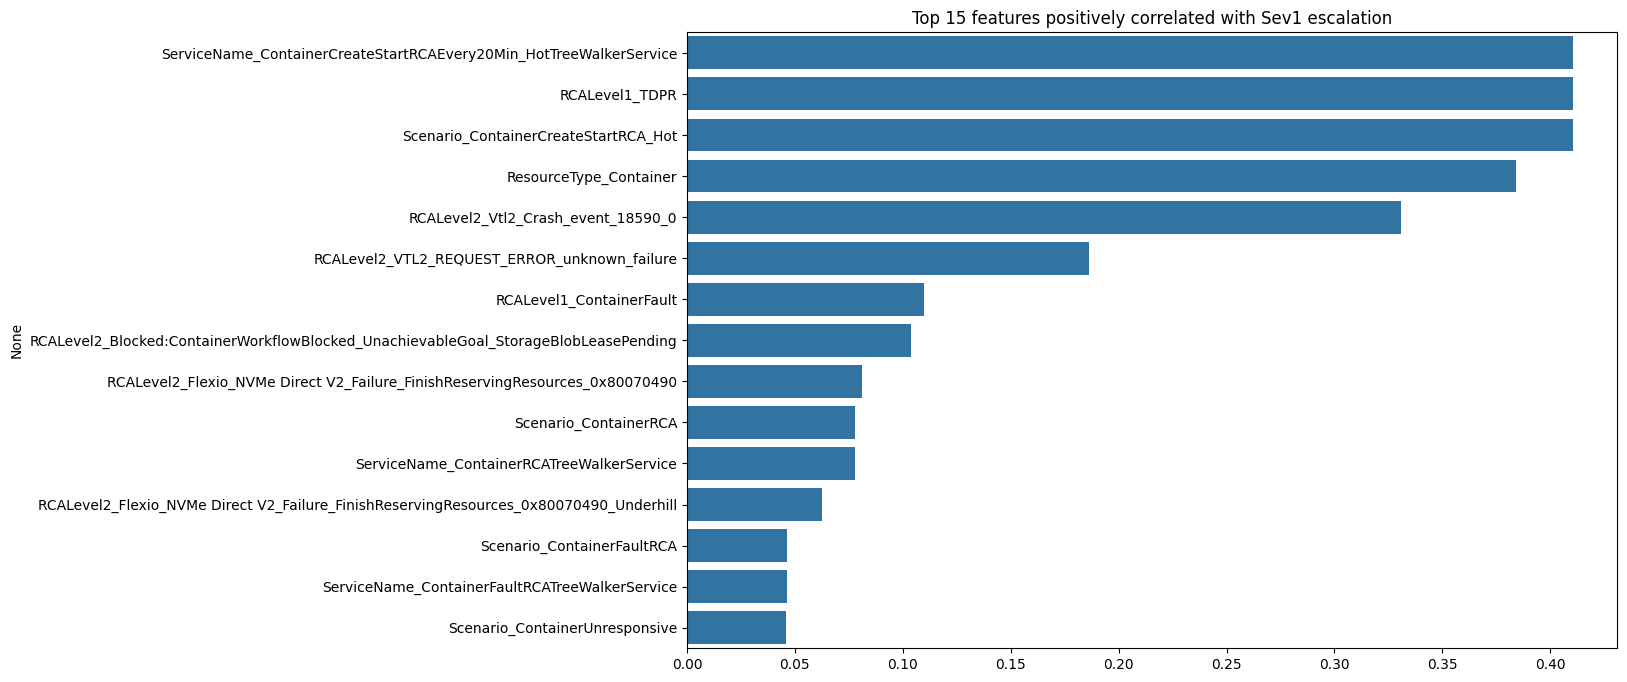

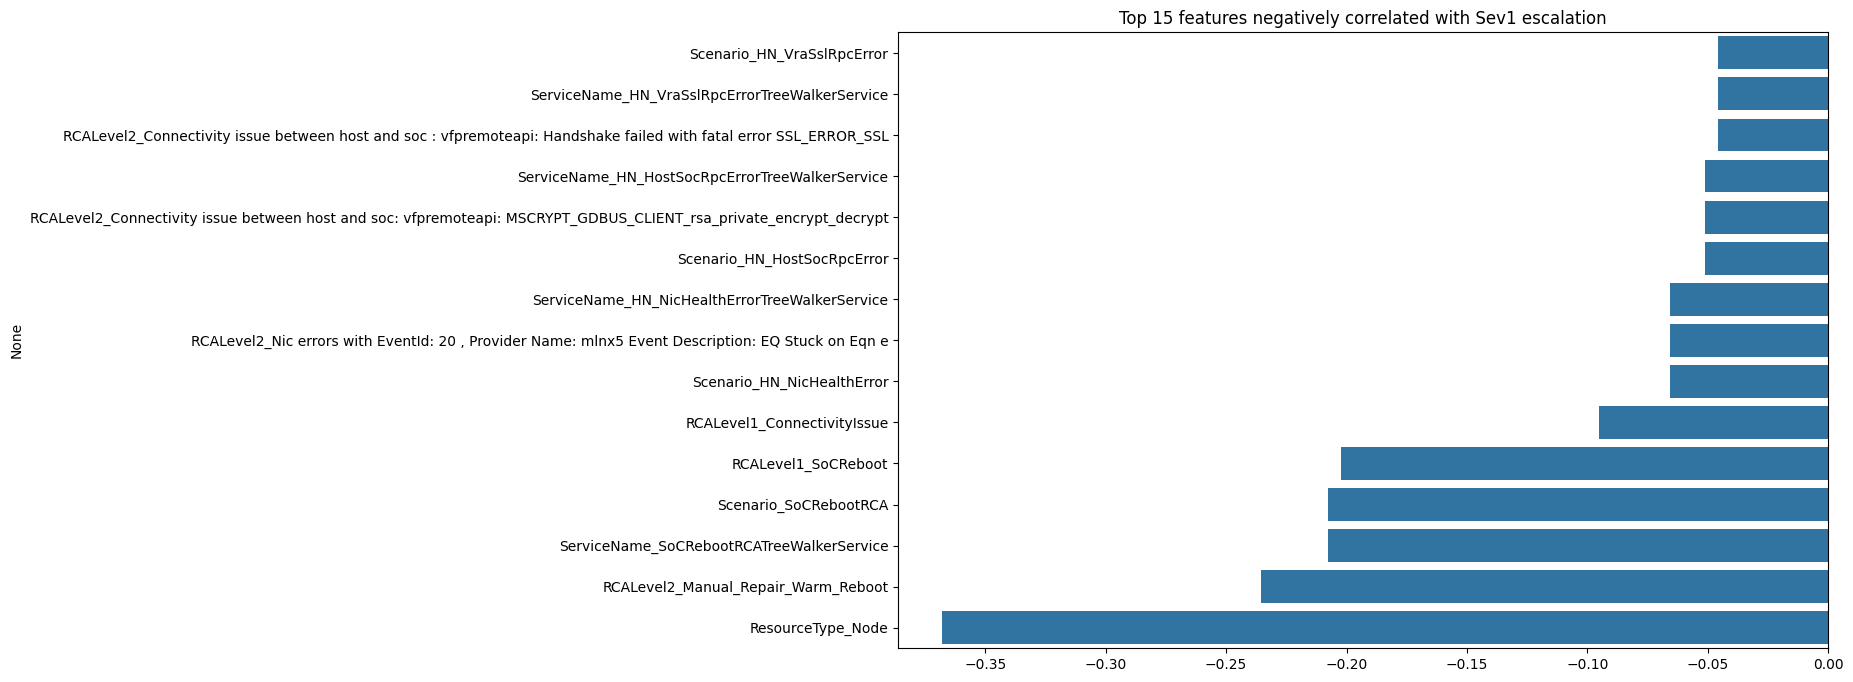

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# this cell needs to be run after 3.1 Creating binary for encoding features
# Only need to uncomment the follwoing line if sev2_with_label.csv file was already created:
# sev2_with_label = pd.read_csv('sev2_with_label.csv')

# One-hot encode all relevant features
features = pd.get_dummies(sev2_with_label[['RCALevel2', 'RCALevel1', 'Scenario', 'ServiceName', 'ResourceType']])
features['Sev1caused'] = sev2_with_label['Sev1caused']

# Compute correlation matrix
corr_matrix = features.corr()

# Show correlation of each feature with the target
target_corr = corr_matrix['Sev1caused'].sort_values(ascending=False)

# Plot top 15 positive and negative correlations
top_features = target_corr[1:16]
bottom_features = target_corr[-15:]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 features positively correlated with Sev1 escalation")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=bottom_features.values, y=bottom_features.index)
plt.title("Top 15 features negatively correlated with Sev1 escalation")
plt.show()